# Project 1: Women's tennis match outcome prediction

The goal of this project is to predict the winning player of a tennis match. My experiment was basen on an WTA dataset found on Kaggle. We will train our models on features such as court types, tournaments, ranking position & ranking scores and a few others.

### Imports and dependencies


In [8]:
import joblib # for saving models
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb # for XGBoost model
import seaborn as sns # for pairplot
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2 # for L2 regularization
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.models import Model
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report, confusion_matrix, precision_score
from mlxtend.frequent_patterns import apriori, association_rules
from base_model import BaseModel, DeepBaseModel
from tensorflow.keras.models import load_model

In [ ]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [9]:
def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath, low_memory=False)

    # Drop rows with missing values and convert columns to numeric
    columns_to_convert = [data.columns[13], data.columns[14]]
    for col in columns_to_convert:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data = data.dropna(subset=[col])
        data = data[data[col] >= 0]

    # Drop row with Date column as it is not needed
    data.drop('Date', axis=1, inplace=True)

    # Encode the categorical columns (as strings are not allowed in the model)
    encoderLabel = LabelEncoder()
    data['Player_1'] = encoderLabel.fit_transform(data['Player_1']).astype(int)
    data['Player_2'] = encoderLabel.fit_transform(data['Player_2']).astype(int)
    data['Tournament'] = encoderLabel.fit_transform(data['Tournament']).astype(int)

    return data

### Adding Winner column
Because in my dataset I only had the score results of a match, I needed to add a separate column determinig the winner in an easy form for the models to work on later on.

In [10]:
def determine_winner(row):
    score = row['Score']
    player_1 = row['Player_1']
    player_2 = row['Player_2']
    sets = score.split()
    player_1_wins = 0
    player_2_wins = 0

    for set_score in sets:
        results = set_score.split('-')
        if len(results) == 2:
            if int(results[0]) > int(results[1]):
                player_1_wins += 1
            elif int(results[1]) > int(results[0]):
                player_2_wins += 1

    if player_1_wins > player_2_wins:
        return player_1
    elif player_2_wins > player_1_wins:
        return player_2
    else:
        return -1

### Data filtering
In order to avoid class imbalance I removed players which only had one win to their name. The score column is dropped after determining the winner to avoid data leakage.

In [11]:
def filter_data(data):
    data['Winner'] = data.apply(determine_winner, axis=1)
    data['Winner'] = data['Winner'].astype(int)

    win_counts = data['Winner'].value_counts()
    players_with_one_win = win_counts[win_counts == 1].index
    filtered_data = data.loc[~data['Player_1'].isin(players_with_one_win) & ~data['Player_2'].isin(players_with_one_win)]

    if 'Score' in filtered_data.columns:
        filtered_data = filtered_data.drop('Score', axis=1)

    return filtered_data



### One Hot encoding and scaling the data

In [12]:
def encode_and_scale_data(filtered_data):
    # One hot encode the categorical columns
    encoder = OneHotEncoder()
    columns_to_encode = ['Court', 'Surface', 'Round']
    data_to_encode = filtered_data[columns_to_encode]

    encoder.fit(data_to_encode)
    encoded_data = encoder.transform(data_to_encode).toarray()
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())
    filtered_data.reset_index(drop=True, inplace=True)
    encoded_df.reset_index(drop=True, inplace=True)

    encoded_df.columns = encoded_df.columns.str.replace(' ', '_')
    filtered_data = pd.concat([filtered_data, encoded_df], axis=1)
    filtered_data = filtered_data.drop(columns=columns_to_encode)

    # Add a column that represents the difference in rank points between the two players
    filtered_data['Rank_Pts_Diff'] = (filtered_data['Pts_1'] - filtered_data['Pts_2']).abs()

    # Scale the numeric columns
    columns_to_scale = ['Odd_1', 'Odd_2', 'Pts_1', 'Pts_2', 'Rank_Pts_Diff']
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(filtered_data[columns_to_scale])
    scaled_data_df = pd.DataFrame(scaled_data, columns=['Scaled_Odd_1', 'Scaled_Odd_2', 'Scaled_Pts_1', 'Scaled_Pts_2', 'Scaled_Rank_Pts_Diff'])

    filtered_data.reset_index(drop=True, inplace=True)
    filtered_data = pd.concat([filtered_data, scaled_data_df], axis=1)
    filtered_data = filtered_data.drop(columns_to_scale, axis=1)

    return filtered_data

### Computing Victory %
In order for our models to have more useful data to work on in hopes of achieving higher accuracy, victory percentage columns were added, where the % of matches won by player1 and player2 are displayed.

In [13]:
def compute_victory_percentages(data):
    player_stats = {}
    victory_percentage_1 = []
    victory_percentage_2 = []

    for index, row in data.iterrows():
        player1 = row['Player_1']
        player2 = row['Player_2']
        winner = row['Winner']

        vp1 = player_stats[player1]['wins'] / player_stats[player1]['matches'] if player1 in player_stats and player_stats[player1]['matches'] > 0 else 0
        vp2 = player_stats[player2]['wins'] / player_stats[player2]['matches'] if player2 in player_stats and player_stats[player2]['matches'] > 0 else 0
        victory_percentage_1.append(vp1)
        victory_percentage_2.append(vp2)

        if player1 not in player_stats:
            player_stats[player1] = {'wins': 0, 'matches': 0}
        if player2 not in player_stats:
            player_stats[player2] = {'wins': 0, 'matches': 0}

        player_stats[player1]['matches'] += 1
        player_stats[player2]['matches'] += 1

        if winner == player1:
            player_stats[player1]['wins'] += 1
        elif winner == player2:
            player_stats[player2]['wins'] += 1

    data['Player_1_Victory_Percentage'] = victory_percentage_1
    data['Player_2_Victory_Percentage'] = victory_percentage_2

    return data

### Displaying how the data looks like after preprocessing


Winner_Binary is added as some models only work/work better on binary labels.

In [14]:
def prepare_and_save_data(filepath):
    data = load_and_preprocess_data(filepath)
    # Filtering the data
    filtered_data = filter_data(data)
    # Add binary column to indicate the winner
    filtered_data['Winner_Binary'] = np.where(filtered_data['Winner'] == filtered_data['Player_1'], 0, 1)
    # Compute victory percentages for each player
    filtered_data = compute_victory_percentages(filtered_data)
    # Drop the Winner column
    filtered_data = filtered_data.drop(columns=['Winner'])
    # Encode and scale the data
    filtered_data = encode_and_scale_data(filtered_data)
    # Save the processed data to a new csv file
    filtered_data.to_csv('processed_filtered_data.csv', index=False)
    return filtered_data

filepath = './wta.csv'
filtered_data = prepare_and_save_data(filepath)
print("Amount of matches left after preprocessing:", len(filtered_data))
print(filtered_data.head())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/

Amount of matches left after preprocessing: 39042
   Tournament  Best of  Player_1  Player_2  Rank_1  Rank_2  Winner_Binary  \
0           3        3       874        52      81     272              0   
1           3        3       621       219      16      59              1   
2           3        3       534        79      56      84              0   
3           3        3       625       175      57      70              1   
4           3        3        66       600      18     180              0   

   Player_1_Victory_Percentage  Player_2_Victory_Percentage  Court_Indoor  \
0                          0.0                          0.0           0.0   
1                          0.0                          0.0           0.0   
2                          0.0                          0.0           0.0   
3                          0.0                          0.0           0.0   
4                          0.0                          0.0           0.0   

   ...  Round_Quarterfin

### Prepare the test and training sets

In [15]:
X = filtered_data.drop(columns=['Winner_Binary'])
y = filtered_data['Winner_Binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Neural Network Model

In [16]:
def create_dense_model(input_shape=(2,), output_shape=2, hidden_units=(32, 64), hidden_activations="relu", last_activation="softmax", dropout_rate=0.5, l2_reg=0.001):
    inputs = Input(shape=input_shape)
    hidden_out = inputs

    for n_cells in hidden_units:
        hidden_out = Dense(n_cells, activation=hidden_activations, kernel_regularizer=l2(l2_reg))(hidden_out)
        hidden_out = BatchNormalization()(hidden_out)
        hidden_out = Dropout(dropout_rate)(hidden_out)

    out = Dense(output_shape, activation=last_activation)(hidden_out)
    return Model(inputs=inputs, outputs=out)

In [17]:
class SimpleFullyConnected(DeepBaseModel):
    def __init__(self, input_shape=(2,), output_shape=2, hidden_units=[32, 64], hidden_activations="relu", last_activation="softmax", dropout_rate=0.5, epochs=30, reduced_lr_epochs=10, optimizer="adam", lr=1e-4, loss="categorical_crossentropy"):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.hidden_units = hidden_units
        self.hidden_activations = hidden_activations
        self.last_activation = last_activation
        self.dropout_rate = dropout_rate
        self.epochs = epochs
        self.reduced_lr_epochs = reduced_lr_epochs
        self.optimizer_name = optimizer
        self.lr = lr
        self.loss = loss
        self.instantiate_model()

    def instantiate_model(self):
        self.scaler_x = StandardScaler()
        self.model = create_dense_model(input_shape=self.input_shape, output_shape=self.output_shape, hidden_units=self.hidden_units, hidden_activations=self.hidden_activations, last_activation=self.last_activation, dropout_rate=self.dropout_rate)

        if self.optimizer_name == "adamax":
            self.optimizer = tf.keras.optimizers.Adamax(learning_rate=self.lr)
        elif self.optimizer_name == "rmsprop":
            self.optimizer = tf.keras.optimizers.RMSprop(learning_rate=self.lr)
        elif self.optimizer_name == "sgd":
            self.optimizer = tf.keras.optimizers.SGD(learning_rate=self.lr)
        elif self.optimizer_name == "adam":
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
        else:
            raise ValueError(f"Optimizer {self.optimizer_name} not understood, must be among ['adam', 'adamax', 'sgd', 'rmsprop']")

        self.model.compile(optimizer=self.optimizer, loss=self.loss, metrics=['accuracy'])

    def fit(self, X, y, class_weights=None):
        self.scaler_x.fit(X)
        if self.output_shape == 2:
            y = tf.keras.utils.to_categorical(y, num_classes=2)
        X_scaled = self.scaler_x.transform(X)

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
        
        return self.model.fit(X_scaled, y, epochs=self.epochs, validation_split=0.1, class_weight=class_weights, callbacks=[early_stopping, reduce_lr])

    def predict(self, X):
        X_scaled = self.scaler_x.transform(X)
        y_pred = self.model.predict(X_scaled)
        if self.output_shape == 2:
            y_pred = np.argmax(y_pred, axis=-1)
        return y_pred

    def save(self, path):
        self.model.save(path)

# Compute class weights
# Misclassifications of minority class instances incur a higher penalty during training
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Initialize and train the model
simple_fc_model = SimpleFullyConnected(input_shape=(X_train.shape[1],), output_shape=2, epochs=40)
history = simple_fc_model.fit(X_train, y_train, class_weights=class_weights)

# Predict and evaluate
y_pred_fc = simple_fc_model.predict(X_test)
precision_fc = precision_score(y_test, y_pred_fc)
accuracy_fc = accuracy_score(y_test, y_pred_fc)
simple_fc_model.save('simple_fc_model_jupyter.h5')

print(f"Precision: {precision_fc}")


2024-05-23 00:05:56.831152: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-05-23 00:05:56.831250: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-23 00:05:56.831264: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-23 00:05:56.831311: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-23 00:05:56.831332: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `n

Epoch 1/40


2024-05-23 00:05:57.422169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


879/879 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.5153 - loss: 1.2041 - val_accuracy: 0.6303 - val_loss: 0.7156 - learning_rate: 1.0000e-04
Epoch 2/40
879/879 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - accuracy: 0.5550 - loss: 0.9441 - val_accuracy: 0.6578 - val_loss: 0.6871 - learning_rate: 1.0000e-04
Epoch 3/40
879/879 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.5690 - loss: 0.8568 - val_accuracy: 0.6684 - val_loss: 0.6774 - learning_rate: 1.0000e-04
Epoch 4/40
879/879 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.5958 - loss: 0.7845 - val_accuracy: 0.6780 - val_loss: 0.6701 - learning_rate: 1.0000e-04
Epoch 5/40
879/879 ━━━━━━━━━━━━━━━━━━━━ 28s 32ms/step - accuracy: 0.6027 - loss: 0.7480 - val_accuracy: 0.6834 - val_loss: 0.6668 - learning_rate: 1.0000e-04
Epoch 6/40
879/879 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.6144 - loss: 0.7258 - val_accuracy: 0.6841 - val_loss: 0.6640 - learning_rate: 1.0000e-04
Epoch 7/40
879/879 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accurac

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Precision: 0.6866022460172369


### XGBoost Model

XGBoost (Extreme Gradient Boosting) is a machine learning algorithm based on decision trees. It works by sequentially adding models to correct errors made by previous models, optimizing for accuracy and speed. It uses gradient boosting, where each new tree reduces the residual errors of prior trees, and it supports regularization to prevent overfitting.

In [18]:
def train_xgboost_model(X_train, y_train, X_test, y_test, params, num_rounds):
    class XGBoost(BaseModel):
        def __init__(self, params, num_rounds=10):
            self.params = params
            self.num_rounds = num_rounds

        def fit(self, X, y, validation_data=None):
            train_data = xgb.DMatrix(X, label=y)
            if validation_data is not None:
                evallist = [
                    (train_data, "train"),
                    (xgb.DMatrix(validation_data[0], label=validation_data[1]), "eval"),
                ]
            else:
                evallist = []
            self.model = xgb.train(self.params, train_data, self.num_rounds, evals=evallist)
            return self.model

        def predict(self, X):
            X = xgb.DMatrix(X)
            return np.round(self.model.predict(X), 0)

        def save(self, path):
            self.model.save_model(path)

    xgb_model = XGBoost(params=params, num_rounds=num_rounds)
    xgb_model.fit(X_train, y_train, validation_data=(X_test, y_test))
    xgb_model.save('xgboost_model2.model')

    return xgb_model

xgb_params = {
        'objective': 'binary:logistic',
        'max_depth': 3,
        'eta': 0.1,
        'eval_metric': 'logloss'
    }
xgb_model = train_xgboost_model(X_train, y_train, X_test, y_test, xgb_params, num_rounds=10)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


[0]	train-logloss:0.67364	eval-logloss:0.67454
[1]	train-logloss:0.65772	eval-logloss:0.65940
[2]	train-logloss:0.64463	eval-logloss:0.64695
[3]	train-logloss:0.63375	eval-logloss:0.63674
[4]	train-logloss:0.62471	eval-logloss:0.62822
[5]	train-logloss:0.61714	eval-logloss:0.62112
[6]	train-logloss:0.61081	eval-logloss:0.61530
[7]	train-logloss:0.60551	eval-logloss:0.61046
[8]	train-logloss:0.60105	eval-logloss:0.60642
[9]	train-logloss:0.59728	eval-logloss:0.60297


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:24:39] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


### Random Forest Model
Random Forest is a ML algorithm that builds multiple decision trees during training and outputs the average prediction of the individual trees. It works by creating a "forest" of randomly sampled data and features, which helps to reduce overfitting and improve generalization. Each tree votes, and the majority vote is taken as the final prediction.

In [19]:
def train_random_forest_model(X_train, y_train, X_test, y_test):
    rf_best = RandomForestClassifier(
        criterion='entropy',
        max_depth=8,
        max_features=0.5,
        n_estimators=300,
        random_state=42
    )

    rf_best.fit(X_train, y_train)
    joblib.dump(rf_best, 'optimized_random_forest_model.pkl')

    return rf_best

rf_model = train_random_forest_model(X_train, y_train, X_test, y_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [20]:
def best_ranked_wins_model(X):
    return np.where(X['Rank_1'] < X['Rank_2'], 0, 1)

y_pred_best_ranked = best_ranked_wins_model(X_test)
precision_best_ranked = precision_score(y_test, y_pred_best_ranked)
print(f"Precision for Best Rank Wins Model: {precision_best_ranked}")

Precision for Best Rank Wins Model: 0.6405011506008693


In [21]:
def random_model(X, seed=42):
    np.random.seed(seed)
    return np.random.randint(0, 2, size=X.shape[0])

y_pred_random = random_model(X_test)
precision_random = precision_score(y_test, y_pred_random)
print(f"Precision for Random Model: {precision_random}")

Precision for Random Model: 0.4894547325102881


In [22]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of the model: {accuracy}")
    print(classification_report(y_test, y_pred))

    return y_pred

print("XGBoost Model:")
y_pred_xgb = evaluate_model(xgb_model, X_test, y_test)
precision_xgb = precision_score(y_test, y_pred_xgb)

print("Random Forest Model:")
y_pred_rf = evaluate_model(rf_model, X_test, y_test)
precision_rf = precision_score(y_test, y_pred_rf)

XGBoost Model:
Accuracy of the model: 0.6854911000128058
              precision    recall  f1-score   support

           0       0.69      0.68      0.68      3926
           1       0.68      0.70      0.69      3883

    accuracy                           0.69      7809
   macro avg       0.69      0.69      0.69      7809
weighted avg       0.69      0.69      0.69      7809

Random Forest Model:
Accuracy of the model: 0.6842105263157895
              precision    recall  f1-score   support

           0       0.69      0.68      0.68      3926
           1       0.68      0.69      0.69      3883

    accuracy                           0.68      7809
   macro avg       0.68      0.68      0.68      7809
weighted avg       0.68      0.68      0.68      7809



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


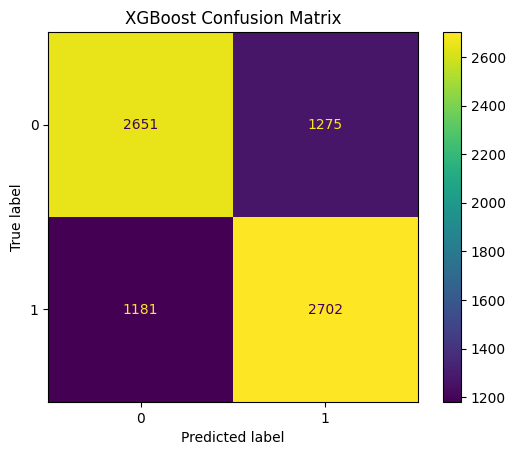

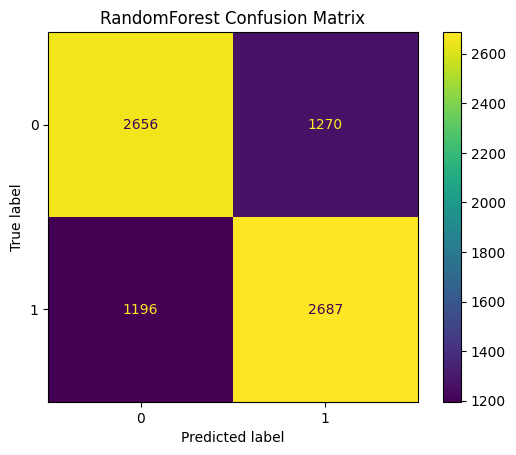

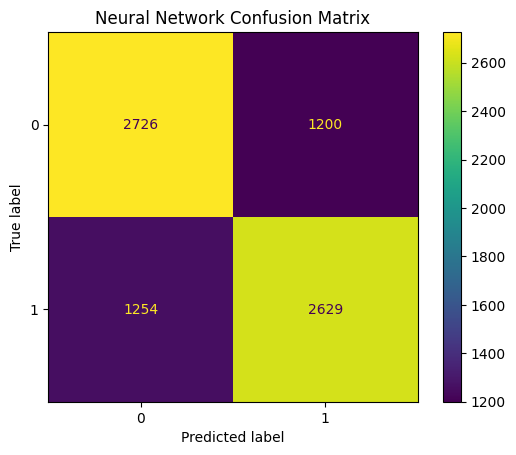

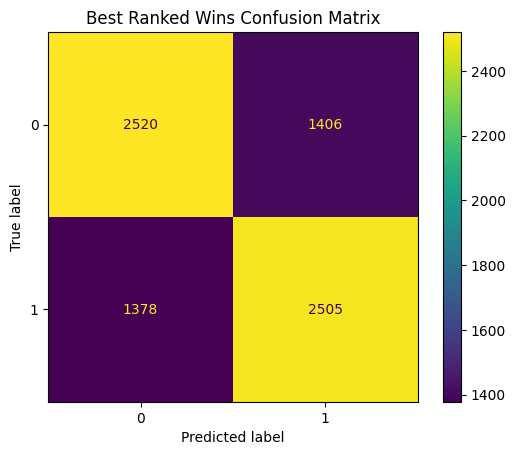

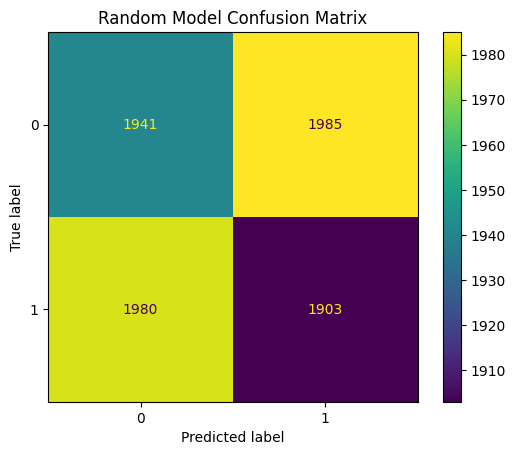

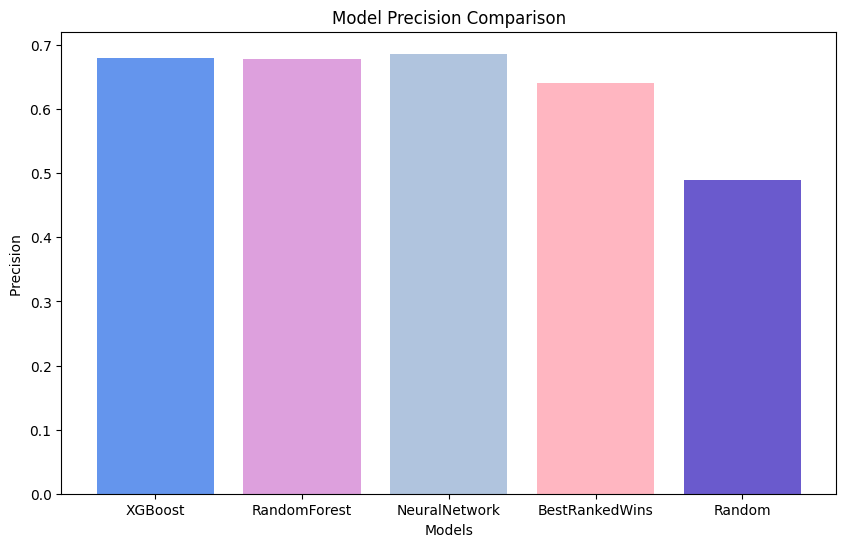

In [31]:
def plot_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_pred_xgb, title='XGBoost Confusion Matrix')
plot_confusion_matrix(y_test, y_pred_rf, title='RandomForest Confusion Matrix')
plot_confusion_matrix(y_test, y_pred_fc, title='Neural Network Confusion Matrix')
plot_confusion_matrix(y_test, y_pred_best_ranked, title='Best Ranked Wins Confusion Matrix')
plot_confusion_matrix(y_test, y_pred_random, title='Random Model Confusion Matrix')


def plot_precision_histogram(precisions, labels, title):
    plt.figure(figsize=(10, 6))
    plt.bar(labels, precisions, color=['cornflowerblue', 'plum', 'lightsteelblue', 'lightpink', 'slateblue', ])
    plt.xlabel('Models')
    plt.ylabel('Precision ')
    plt.title(title)
    plt.show()

precisions = [precision_xgb, precision_rf, precision_fc, precision_best_ranked, precision_random]
labels = ['XGBoost', 'RandomForest', 'NeuralNetwork', 'BestRankedWins', 'Random']
plot_precision_histogram(precisions, labels, 'Model Precision Comparison')

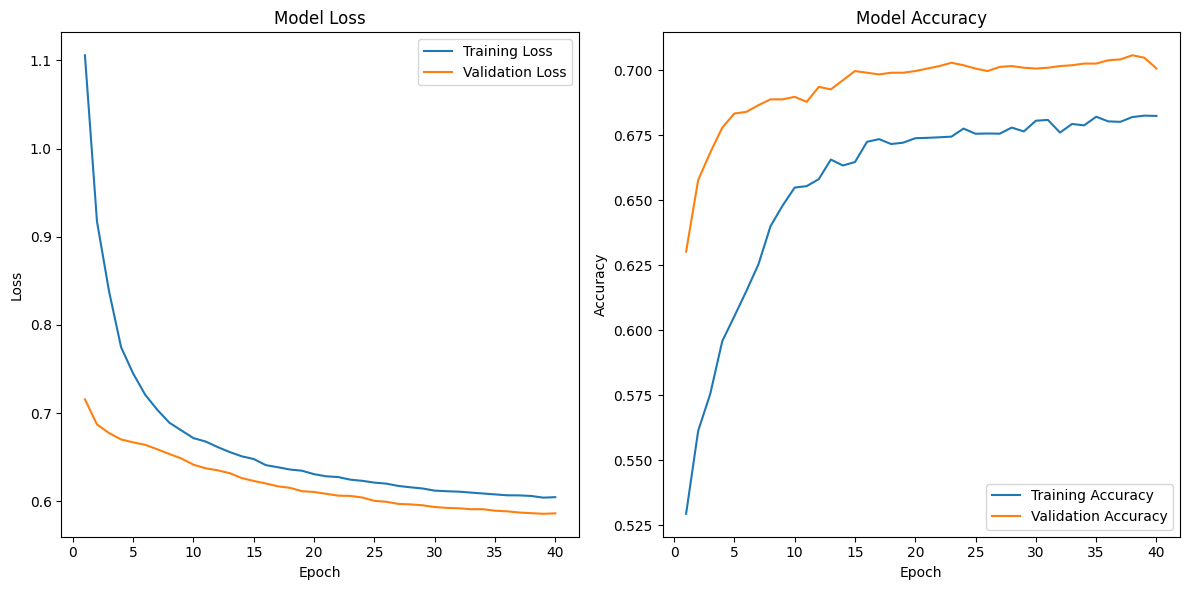

In [24]:
def plot_learning_curve(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize=(12, 6))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curve(history)


In [25]:
def calculate_precision_by_rank(y_test, y_pred_prob, X_test, player_1_rank_groups, player_2_rank_groups):
    precision_matrix = np.zeros((len(player_1_rank_groups), len(player_2_rank_groups)))

    for i, group_1 in enumerate(player_1_rank_groups):
        for j, group_2 in enumerate(player_2_rank_groups):
            mask = (X_test['Rank_1_Grouped'] == group_1) & (X_test['Rank_2_Grouped'] == group_2)
            if np.any(mask):
                y_true_group = y_test[mask]
                y_pred_group = y_pred_prob[mask][:len(y_true_group)] >= 0.5 
                precision_matrix[i, j] = precision_score(y_true_group, y_pred_group, zero_division=0) * 100
            else:
                precision_matrix[i, j] = np.nan 

    return precision_matrix

def plot_precision_heatmap(precision_matrix, title, rank_groups):
    plt.figure(figsize=(10, 7))
    ax = sns.heatmap(precision_matrix, annot=True, fmt=".2f", cmap="RdYlGn", xticklabels=rank_groups, yticklabels=rank_groups, cbar=False)

    # Add text annotations for NaN values
    for i in range(precision_matrix.shape[0]):
        for j in range(precision_matrix.shape[1]):
            if np.isnan(precision_matrix[i, j]):
                ax.text(j + 0.5, i + 0.5, 'No Data', ha='center', va='center', color='black')

    plt.xlabel('Player 1 Rank Group')
    plt.ylabel('Player 2 Rank Group')
    plt.title(title)
    plt.show()



In [26]:
def group_ranks(rank):
        if rank <= 10:
            return '1-10'
        elif rank <= 50:
            return '11-50'
        elif rank <= 100:
            return '51-100'
        elif rank <= 200:
            return '101-200'
        elif rank <= 300:
            return '201-300'
        elif rank <= 500:
            return '301-500'
        else:
            return '501+'
        

filtered_data['Rank_1_Grouped'] = filtered_data['Rank_1'].apply(group_ranks)
filtered_data['Rank_2_Grouped'] = filtered_data['Rank_2'].apply(group_ranks)
X = filtered_data.drop(columns=['Winner_Binary'])
y = filtered_data['Winner_Binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure the rank groups are added to X_test
X_test['Rank_1_Grouped'] = X_test['Rank_1'].apply(group_ranks)
X_test['Rank_2_Grouped'] = X_test['Rank_2'].apply(group_ranks)

# Define rank groups
rank_groups = ['1-10', '11-50', '51-100', '101-200', '201-300', '301-500', '501+']

# Drop the grouped rank columns for predictions
X_test_for_preds = X_test.drop(columns=['Rank_1_Grouped', 'Rank_2_Grouped'])

In [27]:
# Loading saved models
xgb_model = xgb.Booster()
xgb_model.load_model('xgboost_model2.model')

rf_model = joblib.load('optimized_random_forest_model.pkl')
fc_model = load_model('simple_fc_model.h5')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


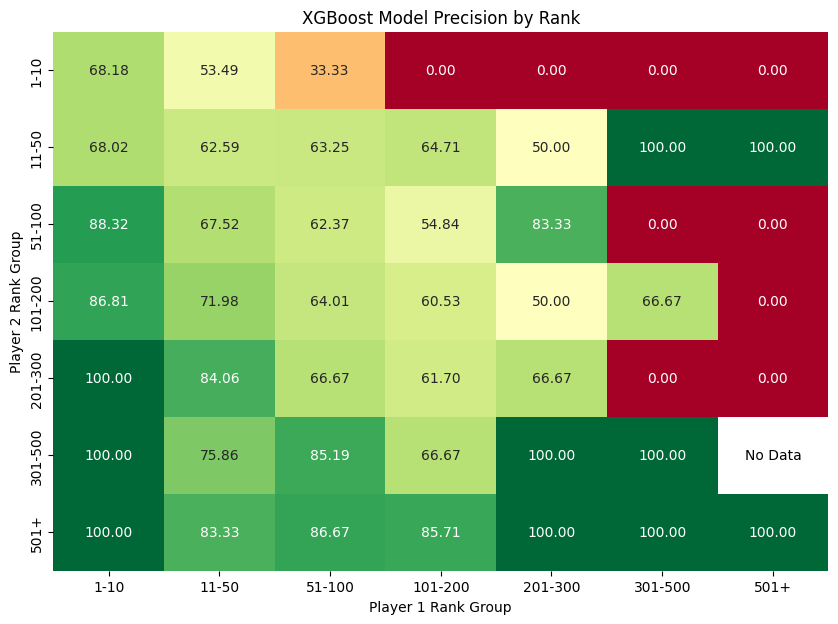

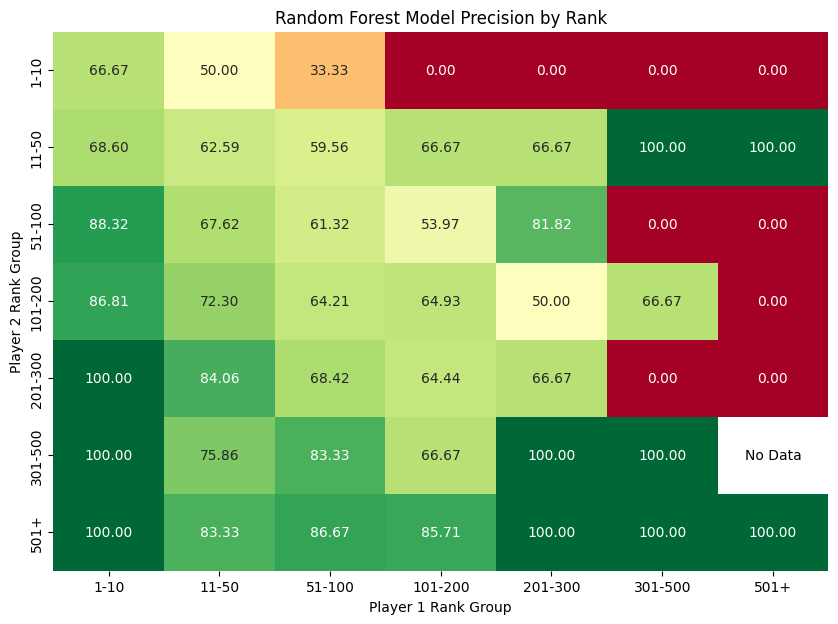

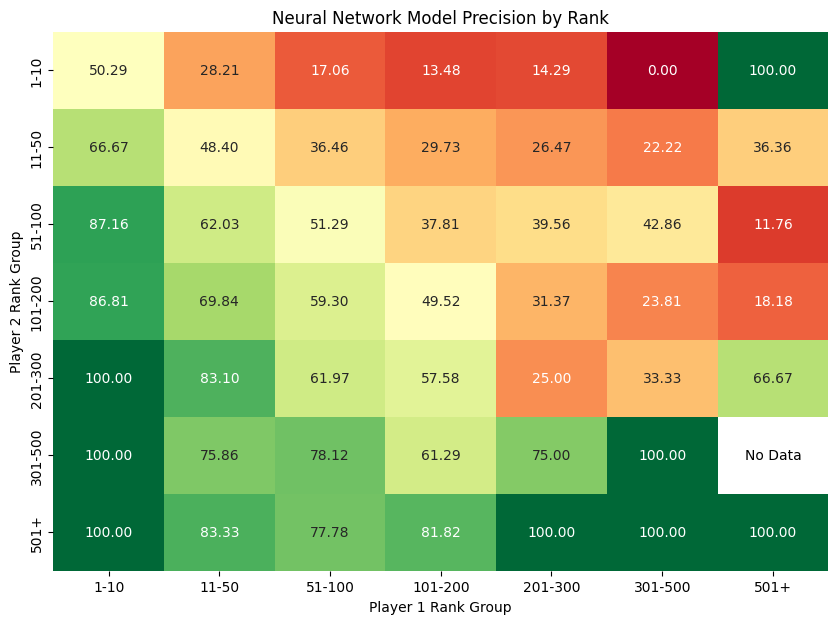

In [28]:
dtest = xgb.DMatrix(X_test_for_preds)
y_pred_prob_xgb = xgb_model.predict(dtest)

# RandomForest predictions
y_pred_prob_rf = rf_model.predict_proba(X_test_for_preds)[:, 1]

# Fully Connected Neural Network predictions
y_pred_prob_fc = fc_model.predict(X_test_for_preds)[:, 1]  # Get the probability of the positive class

# Calculate precision for each model
precision_matrix_xgb = calculate_precision_by_rank(y_test, y_pred_prob_xgb, X_test, rank_groups, rank_groups)
precision_matrix_rf = calculate_precision_by_rank(y_test, y_pred_prob_rf, X_test, rank_groups, rank_groups)
precision_matrix_fc = calculate_precision_by_rank(y_test, y_pred_prob_fc, X_test, rank_groups, rank_groups)

# Plot heatmaps for each model
plot_precision_heatmap(precision_matrix_xgb, 'XGBoost Model Precision by Rank', rank_groups)
plot_precision_heatmap(precision_matrix_rf, 'Random Forest Model Precision by Rank', rank_groups)
plot_precision_heatmap(precision_matrix_fc, 'Neural Network Model Precision by Rank', rank_groups)

### Association rules

In [29]:
# Convert float columns to int
columns_to_encode = [
    'Court_Indoor', 'Court_Outdoor',
    'Surface_Carpet', 'Surface_Clay', 'Surface_Grass', 'Surface_Greenset', 'Surface_Hard',
    'Round_1st_Round', 'Round_2nd_Round', 'Round_3rd_Round', 'Round_4th_Round', 
    'Round_Quarterfinals', 'Round_Round_Robin', 'Round_Semifinals', 'Round_The_Final', 'Round_Third_Place'
]
filtered_data[columns_to_encode] = filtered_data[columns_to_encode].astype(int)

# Categorize ranks based on a threshold
threshold = 150
filtered_data['Rank_1_High'] = (filtered_data['Rank_1'] > threshold).astype(int)
filtered_data['Rank_1_Low'] = (filtered_data['Rank_1'] <= threshold).astype(int)
filtered_data['Rank_2_High'] = (filtered_data['Rank_2'] > threshold).astype(int)
filtered_data['Rank_2_Low'] = (filtered_data['Rank_2'] <= threshold).astype(int)

# Define the final list of columns for association rule mining
columns_for_apriori = columns_to_encode + [
    'Rank_1_High', 'Rank_1_Low', 'Rank_2_High', 'Rank_2_Low'
]

# Extract the relevant subset of the data
df_apriori = filtered_data[columns_for_apriori]

# Apply the Apriori algorithm
frequent_itemsets = apriori(df_apriori, min_support=0.1, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Filter the rules to include only those with at least two items in the antecedents or consequents
filtered_rules = rules[(rules['antecedents'].apply(lambda x: len(x) >= 2)) | 
                       (rules['consequents'].apply(lambda x: len(x) >= 2))]

# Print results
print(frequent_itemsets)
print(filtered_rules)


     support                                           itemsets
0   0.905435                                    (Court_Outdoor)
1   0.280339                                     (Surface_Clay)
2   0.107064                                    (Surface_Grass)
3   0.607807                                     (Surface_Hard)
4   0.469418                                  (Round_1st_Round)
..       ...                                                ...
58  0.210773  (Court_Outdoor, Round_2nd_Round, Rank_1_Low, R...
59  0.214385  (Surface_Hard, Rank_1_Low, Rank_2_Low, Round_1...
60  0.143615  (Surface_Hard, Round_2nd_Round, Rank_1_Low, Ra...
61  0.188131  (Surface_Hard, Round_1st_Round, Rank_1_Low, Co...
62  0.127760  (Surface_Hard, Rank_1_Low, Court_Outdoor, Roun...

[63 rows x 2 columns]
                          antecedents  \
22      (Court_Outdoor, Surface_Clay)   
23   (Court_Outdoor, Round_1st_Round)   
24    (Round_1st_Round, Surface_Clay)   
25                    (Court_Outdoor)   
26  

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


"Court_Outdoor" appears in 90.54% of the transactions.
"Surface_Hard" appears in 60.78% of the transactions.
"(Court_Outdoor, Round_1st_Round) => (Surface_Clay)" -> this combination appears in 13.27% of the transactions. It has a confidence of 31.01%, meaning that when "Court_Outdoor" and "Round_1st_Round" occur together, there is a 31.01% chance that "Surface_Clay" will also be present.
(Round_1st_Round, Surface_Clay) => (Court_Outdoor) -> if a match is the first round on Clay Surface there's a 96.90% chance that it is played outdoors.

    Rule: (Court_Outdoor, Round_1st_Round) => (Surface_Clay)
        Support: 0.278162
        Confidence: 0.307765
        Lift: 1.098
        Interpretation: About 27.82% of transactions involve both outdoor courts and 1st round matches with clay surfaces. When outdoor courts and 1st round matches are involved, there is a 30.78% chance it will be on a clay surface. The lift of 1.098 indicates a slight positive correlation between these conditions and the clay surface.
    
    Rule: (Court_Outdoor) => (Surface_Clay)
        Support: 0.280339
        Confidence: 0.309429
        Lift: 1.105
        Interpretation: About 28.03% of transactions involve outdoor courts with clay surfaces. When outdoor courts are involved, there is a 30.94% chance it will be on a clay surface. The lift of 1.105 indicates a slight positive correlation between outdoor courts and clay surfaces.

    Rule: (Surface_Hard) => (Court_Outdoor)
        Support: 0.605437
        Confidence: 0.995809
        Lift: 1.1
        Interpretation: About 60.54% of transactions involve hard surfaces on outdoor courts. When hard surfaces are involved, there is a 99.58% chance it will be on an outdoor court. The lift of 1.1 indicates a strong positive correlation between hard surfaces and outdoor courts.

### Conclusion

All of my trained models, including XGBoost, Random Forest, and Simple Fully Connected Neural Network, achieved similar precision scores, hovering around 69%. This indicates that while the models are fairly accurate in predicting match outcomes, the nature of sports and its dynamic and unpredictable factors such as player injuries, sudden changes in form, and psychological pressure, limits the models' effectiveness. These factors introduce a level of randomness that current models cannot fully account for. Thus, even with sophisticated algorithms, achieving higher precision remains a challenge due to the unpredictability in sports.

### Bibliography

https://www.kaggle.com/datasets/dissfya/wta-tennis-2007-2023-daily-update

https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost/

https://xgboost.readthedocs.io/en/stable/

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://python-course.eu/machine-learning/training-neural-network-with-python.php

